In [1]:
import cv2
from sklearn.cluster import KMeans
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split
import os
import numpy as np
from xgboost import XGBClassifier
from cv2.xfeatures2d import SIFT_create as sift_create
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as io
from sklearn.preprocessing import LabelEncoder

# Define paths and hyperparameters
data_path            = "fonts-dataset" # the folder containing the data-set
kmeans_sets          = 360  # this is the number of specific SIFT features we are considuring to be "unique"
number_of_estimators = 100  # number of the weak estimators
train_test_ratio     = 0.9  # train set to test set ratio


def show_images(images, titles=None):
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1, n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image, title in zip(images, titles):
        a = fig.add_subplot(1, n_ims, n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()
        
def show_hist(hist):
    plt.plot(hist)
    plt.show()

In [11]:
# Load image paths and labels
# Load image paths and labels
images = []
labels = []
num_images_per_folder = 10  # Set the desired number of images per folder

for folder_name in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder_name)
    folder_images = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path)]
    
    # Limit the number of images loaded from this folder
    folder_images = folder_images[:num_images_per_folder]
    
    for image_path in folder_images:
        label = folder_name  # Assuming folder name represents class label
        images.append(image_path)
        labels.append(label)

print(f"Loaded: {len(images)} images")

images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=(1.0 - train_test_ratio), random_state=42)

print(f"Train Size: {len(images_train)}")
print(f"Test Size : {len(images_test)}")


Loaded: 40 images
Train Size: 36
Test Size : 4


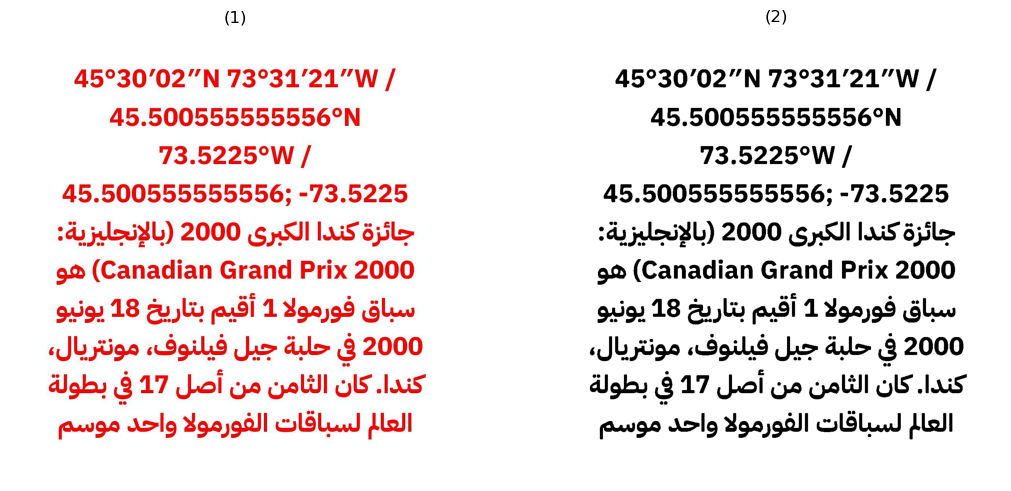

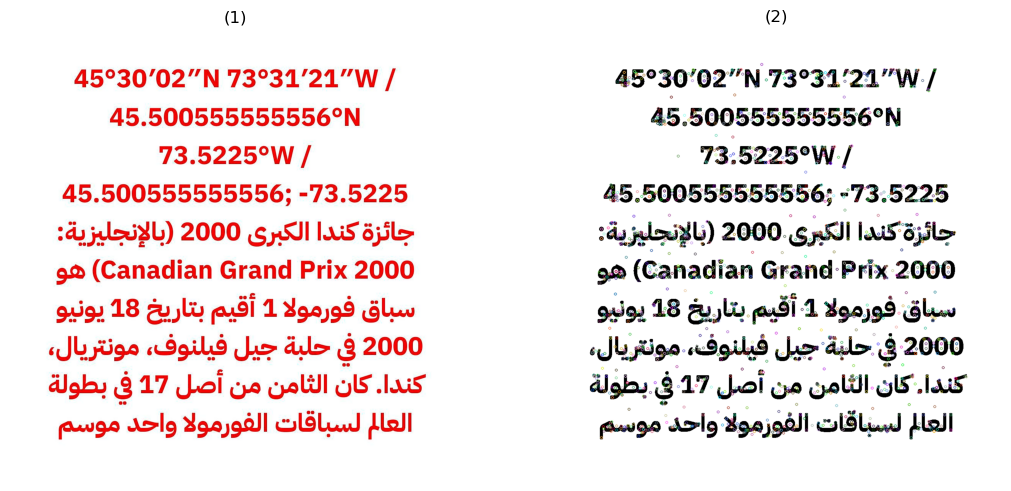

In [12]:
# utility functions
def image_preprocess(img):
    #img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # img = cv2.GaussianBlur(img, (3, 3), 0.1)
    img = cv2.medianBlur(img, 3)  # Kernel size can be adjusted as needed
    histogram = cv2.calcHist([img], [0], None, [256], [0, 256])
    bg_color = np.argmax(histogram)

    thresh = 0
    if bg_color < 50:  # If the background is brighter than a threshold, invert
        _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    else:
        _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY)
    return thresh


def extract_features(img):
  surf = sift_create()
  keypoints, descriptors = surf.detectAndCompute(img, None)
  return keypoints, descriptors


def create_image_histogram(img, kmeans):
  descriptors = extract_features(img)[1]
  histogram = np.zeros(kmeans_sets)
  if (descriptors is None or len(descriptors) == 0):
    return histogram
  
  prediction = kmeans.predict(descriptors)
  for p in prediction:
    histogram[p] += 1
  return histogram


def create_histogram(features , kmeans):
  histogram = np.zeros(kmeans_sets)
  if (features is None or len(features) == 0):
    return histogram
  
  prediction = kmeans.predict(features)
  for p in prediction:
    histogram[p] += 1
  return histogram


# functions test
test_image = cv2.imread(images_train[0])
test_processed_image = image_preprocess(test_image)
test_keypoints, test_descriptors = extract_features(test_processed_image)

show_images([test_image , test_processed_image])
test_image_with_kp = cv2.drawKeypoints(test_processed_image, test_keypoints, None, flags=0)
show_images([test_image , test_image_with_kp])

In [13]:
from sklearn.decomposition import PCA

def apply_pca(descriptors, n_components=64):
    pca = PCA(n_components=n_components)
    descriptors_reduced = pca.fit_transform(descriptors)
    return descriptors_reduced

In [14]:
# now we need to extract images features
# then we apply a kmeans algorithm to be
# able to optain histogram if the images
# features to compair with
print("Loading all images features..")
i = 0
last = 0
all_features = []
for image_path in images_train:
    img = cv2.imread(image_path)
    processed = image_preprocess(img)
    keypoints, descriptors = extract_features(processed)
    descriptors_reduced = apply_pca(descriptors, n_components=64)  # Apply PCA
    all_features.append(descriptors)
    i = i + 1
    if (i * 100 // len(images_train) >= last + 10):
        last = i * 100 // len(images_train)
        print(f"Progress: {i * 100 / len(images_train)} %")

Loading all images features..
Progress: 11.11111111111111 %
Progress: 22.22222222222222 %
Progress: 33.333333333333336 %
Progress: 44.44444444444444 %
Progress: 55.55555555555556 %
Progress: 66.66666666666667 %
Progress: 77.77777777777777 %
Progress: 88.88888888888889 %
Progress: 100.0 %


In [15]:
# Load Kmeans from file
print("Preparing Kmeans (Bag of words)")
kmeans = None
with open('kmeans_model_pca.pkl', 'rb') as f:
    kmeans = pickle.load(f)
if kmeans is not None:
    print("Loaded")
else:
    print("Failed to Load")

Preparing Kmeans (Bag of words)


FileNotFoundError: [Errno 2] No such file or directory: 'kmeans_model_pca.pkl'

In [18]:
# Or use the trained data (will take alot "LIKE ALOT" of time)
print("Preparing Kmeans (Bag of words)")
kmeans = KMeans(n_clusters=kmeans_sets)

filtered_list = [item for item in all_features if item is not None]
print(filtered_list)
kmeans.fit(np.concatenate(filtered_list))  # Combine all descriptors
print("Done!")

Preparing Kmeans (Bag of words)
[array([[ 13., 120.,  68., ...,   0.,   0.,   5.],
       [  0.,   0.,   0., ...,  63.,   7.,   3.],
       [  2.,   1., 141., ...,   0.,   0.,   1.],
       ...,
       [  0.,   0.,   2., ...,   0.,   0.,   1.],
       [  0.,   0., 112., ...,   0.,   0.,   0.],
       [  0.,  59., 146., ...,   0.,   0.,   3.]], dtype=float32), array([[ 17.,  15.,  41., ...,   0.,   0.,   2.],
       [  6.,  63., 127., ...,   0.,   0.,   1.],
       [  0.,   0.,   1., ...,  17.,  12.,   2.],
       ...,
       [ 28.,   1.,   0., ...,  36., 101.,  17.],
       [  0.,   1.,   9., ...,   0.,   0.,   7.],
       [  0.,   1.,  76., ...,   0.,   0.,   2.]], dtype=float32), array([[  0.,   7.,   2., ...,   0.,   0.,   1.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [131., 118.,   1., ...,   0.,   0.,  12.],
       ...,
       [  0.,   7.,  58., ...,   0.,   9.,   6.],
       [  0.,   0.,   5., ...,   0.,   0.,  12.],
       [  0.,   0.,   0., ...,   2.,   9.,  12.

c:\Users\HIMA\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
# Create histograms for training images
images_features = []
for feature in all_features:
  histogram = create_histogram(feature, kmeans)
  images_features.append(histogram)

print(f"Created : {len(images_features)} images features")

NameError: name 'all_features' is not defined

In [ ]:
# Load the classifier from file
clf = None
with open('classifier_ada_pca.pkl', 'rb') as f:
    clf = pickle.load(f)
if clf is not None:
    print("Loaded")
else:
    print("Failed to Load")

Loaded


In [ ]:
# XG classifier
clf = XGBClassifier(random_state=42,n_estimators=number_of_estimators)

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels_train)
labels_encoded = labels_encoded.astype(np.int32)  # Convert to np.int32
print(labels_encoded.shape)
print(np.array(images_features).shape)

clf.fit(np.array(images_features), labels_encoded)

(3600,)
(3600, 360)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
# AdaBoost classifier
clf = AdaBoostClassifier(n_estimators=number_of_estimators, random_state=42)
clf.set_params(algorithm="SAMME")
clf.set_params(estimator=SVC(kernel='linear'))  # Set the base learner

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels_train)
labels_encoded = labels_encoded.astype(np.int32)  # Convert to np.int32
print(labels_encoded.shape)
print(np.array(images_features).shape)

clf.fit(np.array(images_features), labels_encoded)

(3600,)
(3600, 360)


AdaBoostClassifier(algorithm='SAMME', estimator=SVC(kernel='linear'),
                   n_estimators=100, random_state=42)

In [ ]:
def classify_image(image_path, kmeans, clf):
  img = cv2.imread(image_path)
  img = image_preprocess(img)
  histogram = create_image_histogram(img, kmeans)
  prediction = clf.predict([histogram])[0]
  return prediction


label_encoder = LabelEncoder()
tests_encoded = label_encoder.fit_transform(labels_test)
tests_encoded = tests_encoded.astype(np.int32)  # Convert to np.int32

wrong = []
for img, answer in zip(images_test , tests_encoded):
  predicted_class = classify_image(img, kmeans, clf)
  print("Predicted class for", img, ":", predicted_class)
  if (predicted_class != answer):
    wrong.append(img)


print(f"Errors: {len(wrong)}")
if len(wrong) != 0:
  for w in wrong:
    print(f"\t{w}")
print(f"accuriacy : {100 - len(wrong) / len(tests_encoded) * 100}")

Predicted class for fonts-dataset\IBM Plex Sans Arabic\599.jpeg : 0
Predicted class for fonts-dataset\Scheherazade New\540.jpeg : 3
Predicted class for fonts-dataset\IBM Plex Sans Arabic\573.jpeg : 0
Predicted class for fonts-dataset\Scheherazade New\931.jpeg : 3
Predicted class for fonts-dataset\Marhey\99.jpeg : 2
Predicted class for fonts-dataset\IBM Plex Sans Arabic\161.jpeg : 0
Predicted class for fonts-dataset\Lemonada\78.jpeg : 1
Predicted class for fonts-dataset\IBM Plex Sans Arabic\289.jpeg : 0
Predicted class for fonts-dataset\IBM Plex Sans Arabic\275.jpeg : 0
Predicted class for fonts-dataset\IBM Plex Sans Arabic\821.jpeg : 0
Predicted class for fonts-dataset\Scheherazade New\467.jpeg : 3
Predicted class for fonts-dataset\Scheherazade New\851.jpeg : 3
Predicted class for fonts-dataset\Lemonada\23.jpeg : 1
Predicted class for fonts-dataset\Lemonada\547.jpeg : 1
Predicted class for fonts-dataset\Scheherazade New\871.jpeg : 3
Predicted class for fonts-dataset\Scheherazade New\53

In [ ]:
# playground ..
new_image_path = f"fonts-dataset/Lemonada/360.jpeg"
img = cv2.imread(new_image_path)
img = image_preprocess(img)
print(img.shape)


(1181, 1181)


In [ ]:
# outputing to files:
with open('kmeans_model_pca.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

with open('ada_classifier_pca.pkl', 'wb') as f:
    pickle.dump(clf, f)
